In [10]:
import json
import copy
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras_tuner
from dataclasses import dataclass
from typing import List
from keras import layers, ops
from keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata
%matplotlib inline

from processing import Stationarizer, Normalizer
from analysis import get_trials, get_RMSEs, make_histogram, plot_lrs, get_trials_df
from plotting import visualize_loss, show_plot
from model_builder import build_model, build_spec_model, get_tuner

2024-08-08 22:57:38.226413: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
trials = get_trials(238, "stock_predictor_2024-08-04 15:49:56.383797")
trials = get_RMSEs(trials)

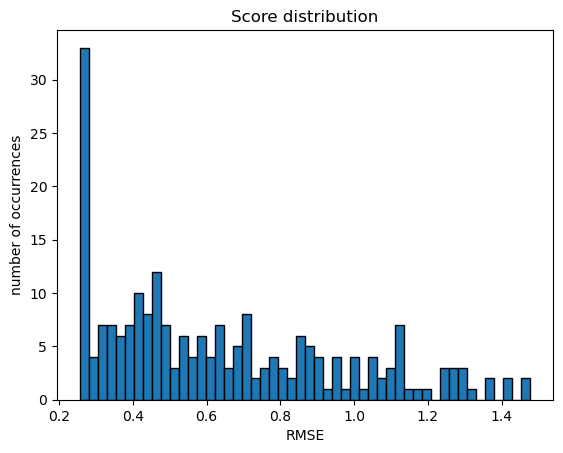

In [12]:
counts = make_histogram(trials, num_bins=50, width=0.025)

In [13]:
df = get_trials_df(trials)
df[:15]

,selu,activation,dropout_0,recurrent_dropout_0,dropout_1,recurrent_dropout_1,kernel_initializer_2,lr,trial id,rmse,mse,best step,total dropout
0,False,silu,0.245196,0.109664,0.550095,0.185896,he_uniform,0.002246,190,0.071703,0.005141,6,0.795291
1,False,gelu,0.456261,0.220056,0.302563,0.008603,he_uniform,0.003385,028,0.082421,0.006793,4,0.758824
2,False,silu,0.553303,0.204177,0.306235,0.031346,he_uniform,0.003980,185,0.090102,0.008118,5,0.859538
3,False,gelu,0.383189,0.007958,0.459823,0.197446,glorot_uniform,0.002259,044,0.090156,0.008128,6,0.843012
4,False,silu,0.454869,0.224840,0.263981,0.056996,he_uniform,0.003588,141,0.090883,0.008260,8,0.718851
5,False,silu,0.229208,0.100294,0.590209,0.172058,he_normal,0.002381,175,0.094367,0.008905,6,0.819417
6,False,gelu,0.416816,0.015289,0.560383,0.246967,glorot_normal,0.001953,064,0.100009,0.010002,5,0.977199
7,False,gelu,0.530490,0.225745,0.451170,0.146492,glorot_normal,0.002302,212,0.101557,0.010314,4,0.981659
8,False,gelu,0.569161,0.016937,0.324162,0.097187,glorot_normal,0.002741,196,0.120588,0.014541,4,0.893323
9,False,gelu,0.465267,0.163898,0.284699,0.165897,he_normal,0.001798,199,0.120883,0.014613,9,0.749966


In [14]:
convergent = df[df["best step"] >= 40]
divergent = df[df["best step"] < 40]

Text(0, 0.5, 'LSTM layer 2 dropout')

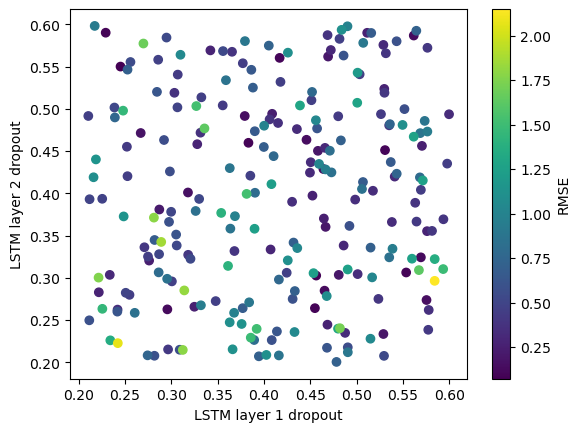

In [15]:
plt.scatter(df.loc[:, "dropout_0"], df.loc[:, "dropout_1"], c=df.loc[:, "rmse"])
plt.colorbar(label="RMSE")
plt.xlabel("LSTM layer 1 dropout")
plt.ylabel("LSTM layer 2 dropout")

Text(0.5, 1.0, 'Model RMSE vs. dropout rates')

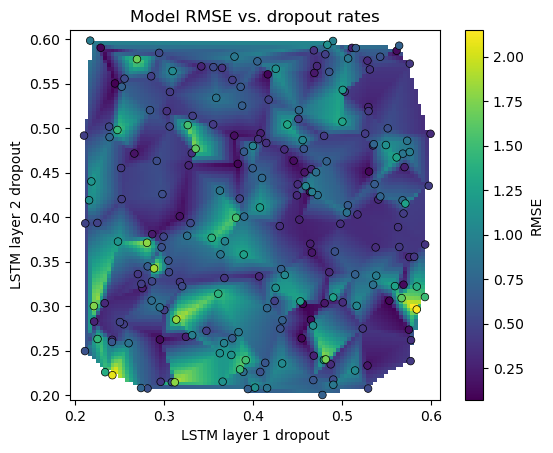

In [16]:
x = df.loc[:, "dropout_0"].to_numpy()
y = df.loc[:, "dropout_1"].to_numpy()
min_coord = 0.195 #min((min(x), min(y)))
max_coord = 0.61 #max((max(x), max(y)))
grid_x, grid_y = np.mgrid[min_coord:max_coord:100j, min_coord:max_coord:100j]
points = list(zip(x, y))
vals = df.loc[:, "rmse"]
grid_z = griddata(points, vals, (grid_x, grid_y), method="linear")
plt.imshow(grid_z.T, extent=(min_coord, max_coord, min_coord, max_coord), origin="lower")
plt.scatter(df.loc[:, "dropout_0"], df.loc[:, "dropout_1"], s=30, c=df.loc[:, "rmse"], marker="o", edgecolor="black", linewidth=0.5)
plt.xlabel("LSTM layer 1 dropout")
plt.ylabel("LSTM layer 2 dropout")
plt.colorbar(label="RMSE")
plt.title("Model RMSE vs. dropout rates")

Text(0.5, 1.0, 'Model RMSE vs. dropout rates')

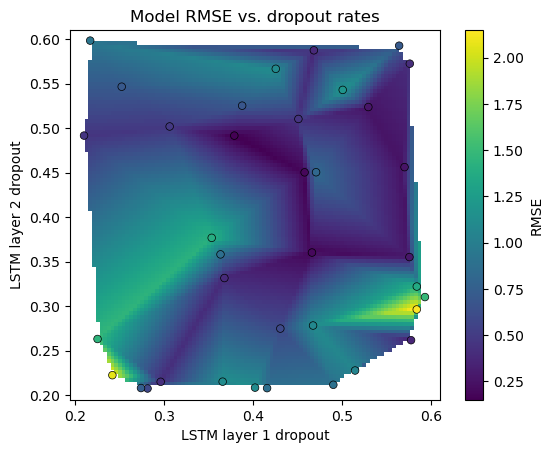

In [17]:
x = convergent.loc[:, "dropout_0"].to_numpy()
y = convergent.loc[:, "dropout_1"].to_numpy()
min_coord = 0.195 #min((min(x), min(y)))
max_coord = 0.61 #max((max(x), max(y)))
grid_x, grid_y = np.mgrid[min_coord:max_coord:100j, min_coord:max_coord:100j]
points = list(zip(x, y))
vals = convergent.loc[:, "rmse"]
grid_z = griddata(points, vals, (grid_x, grid_y), method="linear")
plt.imshow(grid_z.T, extent=(min_coord, max_coord, min_coord, max_coord), origin="lower")
plt.scatter(convergent.loc[:, "dropout_0"], convergent.loc[:, "dropout_1"], s=30, c=convergent.loc[:, "rmse"], marker="o", edgecolor="black", linewidth=0.5)
plt.xlabel("LSTM layer 1 dropout")
plt.ylabel("LSTM layer 2 dropout")
plt.colorbar(label="RMSE")
plt.title("Model RMSE vs. dropout rates")

In [26]:
reg = LinearRegression()

Text(0, 0.5, 'RMSE')

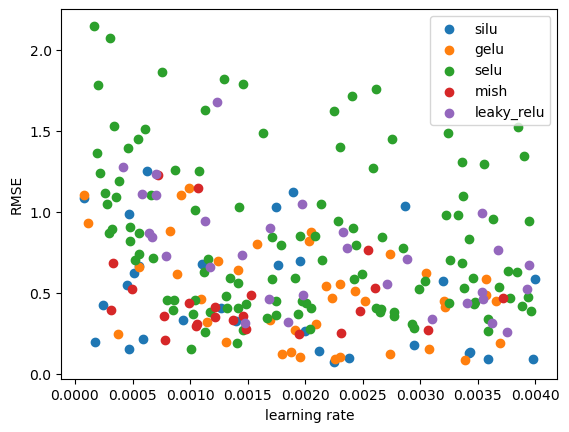

In [37]:
df.loc[df["selu"], "activation"] = "selu"
df.loc[df["selu"], "activation"] = "selu"

#plt.scatter(df["lr"], df["rmse"])
df[df["selu"]]
acts = df["activation"].unique()
for act in acts:
    x = df.loc[df["activation"] == act, "lr"]
    y = df.loc[df["activation"] == act, "rmse"]
    plt.scatter(x, y, label=act)
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("RMSE")
#plt.xscale("log")

Text(0, 0.5, 'RMSE')

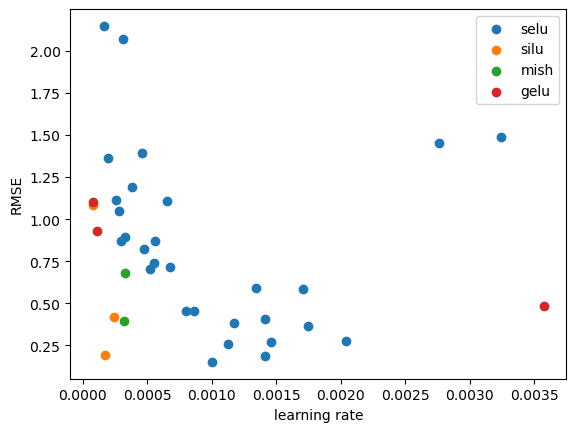

In [38]:
convergent.loc[convergent["selu"], "activation"] = "selu"
convergent.loc[convergent["selu"], "activation"] = "selu"

#plt.scatter(df["lr"], df["rmse"])
df[df["selu"]]
acts = convergent["activation"].unique()
for act in acts:
    plt.scatter(convergent.loc[convergent["activation"] == act, "lr"], convergent.loc[convergent["activation"] == act, "rmse"], label=act)
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("RMSE")
#plt.xscale("log")

Text(0, 0.5, 'RMSE')

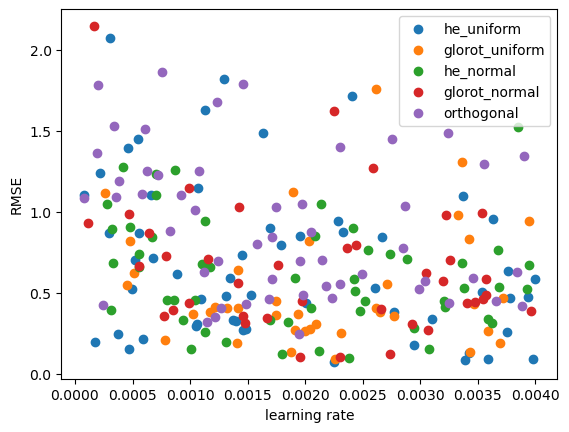

In [39]:
inits = df["kernel_initializer_2"].unique()
for init in inits:
    plt.scatter(df.loc[df["kernel_initializer_2"] == init, "lr"], df.loc[df["kernel_initializer_2"] == init, "rmse"], label=init)
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("RMSE")
#plt.xscale("log")

Text(0, 0.5, 'RMSE')

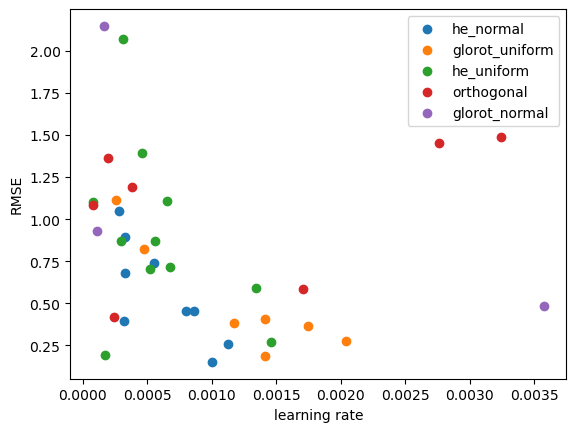

In [21]:
inits = convergent["kernel_initializer_2"].unique()
for init in inits:
    plt.scatter(convergent.loc[convergent["kernel_initializer_2"] == init, "lr"], convergent.loc[convergent["kernel_initializer_2"] == init, "rmse"], label=init)
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("RMSE")
#plt.xscale("log")

Text(0.5, 1.0, 'Model RMSE vs. recurrent dropout rates')

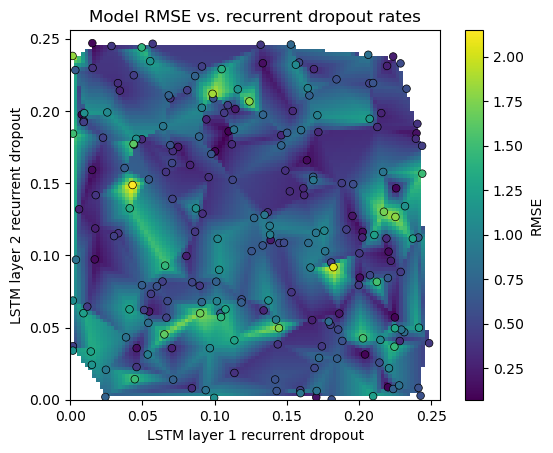

In [40]:
x = df.loc[:, "recurrent_dropout_0"].to_numpy()
y = df.loc[:, "recurrent_dropout_1"].to_numpy()
min_coord = 0 #min((min(x), min(y)))
max_coord = 0.256 #max((max(x), max(y)))
grid_x, grid_y = np.mgrid[min_coord:max_coord:100j, min_coord:max_coord:100j]
points = list(zip(x, y))
vals = df.loc[:, "rmse"]
grid_z = griddata(points, vals, (grid_x, grid_y), method="linear")
plt.imshow(grid_z.T, extent=(min_coord, max_coord, min_coord, max_coord), origin="lower")
plt.scatter(df.loc[:, "recurrent_dropout_0"], df.loc[:, "recurrent_dropout_1"], s=30, c=df.loc[:, "rmse"], marker="o", edgecolor="black", linewidth=0.5)
plt.xlabel("LSTM layer 1 recurrent dropout")
plt.ylabel("LSTM layer 2 recurrent dropout")
plt.colorbar(label="RMSE")
plt.title("Model RMSE vs. recurrent dropout rates")

Text(0.5, 1.0, 'Model RMSE vs. recurrent dropout rates')

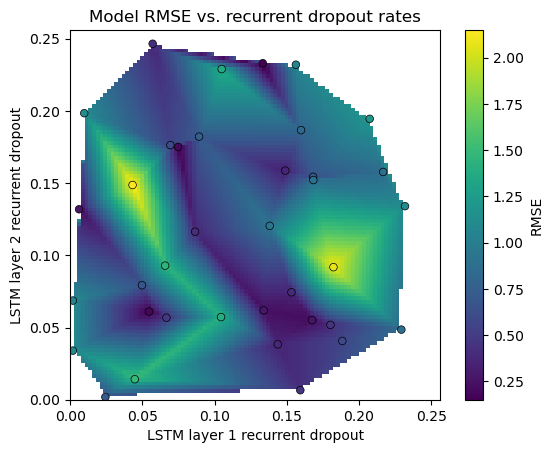

In [41]:
x = convergent.loc[:, "recurrent_dropout_0"].to_numpy()
y = convergent.loc[:, "recurrent_dropout_1"].to_numpy()
min_coord = 0 #min((min(x), min(y)))
max_coord = 0.256 #max((max(x), max(y)))
grid_x, grid_y = np.mgrid[min_coord:max_coord:100j, min_coord:max_coord:100j]
points = list(zip(x, y))
vals = convergent.loc[:, "rmse"]
grid_z = griddata(points, vals, (grid_x, grid_y), method="linear")
plt.imshow(grid_z.T, extent=(min_coord, max_coord, min_coord, max_coord), origin="lower")
plt.scatter(convergent.loc[:, "recurrent_dropout_0"], convergent.loc[:, "recurrent_dropout_1"], s=30, c=convergent.loc[:, "rmse"], marker="o", edgecolor="black", linewidth=0.5)
plt.xlabel("LSTM layer 1 recurrent dropout")
plt.ylabel("LSTM layer 2 recurrent dropout")
plt.colorbar(label="RMSE")
plt.title("Model RMSE vs. recurrent dropout rates")

Text(0, 0.5, 'RMSE')

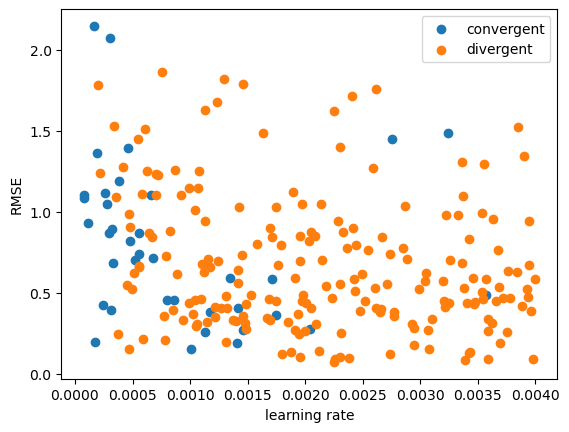

In [42]:
inits = df["kernel_initializer_2"].unique()
plt.scatter(convergent["lr"], convergent["rmse"], label="convergent")
plt.scatter(divergent["lr"], divergent["rmse"], label="divergent")
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("RMSE")

In [25]:
convergent[:15]

,selu,activation,dropout_0,recurrent_dropout_0,dropout_1,recurrent_dropout_1,kernel_initializer_2,lr,trial id,rmse,mse,best step,total dropout
14,True,selu,0.379181,0.133358,0.491556,0.233074,he_normal,0.001005,131,0.151368,0.022912,45,0.870736
18,True,selu,0.458125,0.054596,0.450308,0.061070,glorot_uniform,0.001411,046,0.187545,0.035173,50,0.908433
20,False,silu,0.466395,0.074707,0.360243,0.175137,he_uniform,0.000174,101,0.194345,0.037770,58,0.826638
27,True,selu,0.570323,0.167530,0.456166,0.055135,he_normal,0.001125,119,0.255127,0.065090,49,1.026489
31,True,selu,0.529675,0.006087,0.523655,0.131922,he_uniform,0.001456,179,0.267015,0.071297,40,1.053330
34,True,selu,0.575815,0.133935,0.355183,0.061874,glorot_uniform,0.002039,048,0.275044,0.075649,57,0.930999
56,True,selu,0.577625,0.148958,0.261842,0.158719,glorot_uniform,0.001750,033,0.363460,0.132103,55,0.839467
60,True,selu,0.468520,0.143725,0.587342,0.038357,glorot_uniform,0.001171,234,0.381398,0.145464,58,1.055862
65,False,mish,0.368064,0.153196,0.331641,0.074445,he_normal,0.000317,221,0.393161,0.154576,41,0.699705
71,True,selu,0.576248,0.086437,0.572333,0.116362,glorot_uniform,0.001415,152,0.407953,0.166425,43,1.148581
